# Pipeline Rayanne : CSP and XDAWN

Organisation de la pipeline: 

- **Set up**
    - Les mouvements de flexion/extension sont identifiés et ajoutés à l'objet raw MNE (id = 1 pour extension, id = 2 pour flexion)
    - Filtrage spatial (seul le côté lésé est gardé, et les électrodes du cortex moteur)
    - Filtrage temporel (de 1 à 50 Hz)
    - Récupération d'époques autour des extensions, flexions, et des périodes de non mouvement

- **Chargement des données**
    - Les époques/labels sont séparés par session (groupement des trials 1/3 VS trial 2)

- **Fonctions d'évaluation, de validation et de test**
    - Évaluation à l'aide d'une cross validation sur les données d'entrainement
    - Score sur les données de test
    - Différentes approches pour l'évaluation:
        - Entrainement et validation sur les sessions 1 et 3, test sur les sessions 1 et 3
        - Entrainement et validation sur les sessions 1 et 3, test sur la session 2
        - Entrainement et validation sur les sessions 1, 2 et 3, test sur les sessions 1, 2 et 3

- **Pipelines**
    - Covariance + Tangent Space + Standard Scaler + Random Forest
    - CSP + LDA
    - CSP + SVM
    - CSP + Random forest
    - xDAWN + Vectorizer + Scaler + LogReg


**A FAIRE**
- Epoques seulement autour des extensions et oublier les flexions
- Sliding windows pour les tests

## Set up

### Imports

In [5]:
# Run the following command to install the required packages:
# !pip install -r requirements.txt
# !pip install -e ./../../src

In [2]:
from preprocessing import DataLoader
import os
import pandas as pd
import numpy as np
import mne
from mne import find_events

%matplotlib inline
import matplotlib.pyplot as plt

### Fonction pour le préprocessing, avec filtrage spatial

In [3]:
def get_channels(raws, side):
    endings = ('1', '3', '5', '7', '9') if side=='D' else ('2', '4', '6', '8', '10')
    channels_to_remove = [channel for channel in raws.ch_names if channel.endswith(endings)]
    channels = [channel for channel in raws.ch_names if channel not in channels_to_remove]
    return channels

In [23]:
# Paramètres
motor_electrods_dict = {'G': ['FC1', 'FC3', 'FC5',
                                'C1', 'C3', 'C5',
                                'CP1', 'CP3', 'CP5'
                            ],
                        'D': ['FC2', 'FC4', 'FC6', 
                                'C2', 'C4', 'C6',
                                'CP2', 'CP4', 'CP6'
                            ]
                        }
F_LOW = 1
F_HIGH = 50

EPOCHS_TMIN = -1.
EPOCHS_TMAX = 3.

# Temps avant un mouvement que l'on considère sans mouvement
EPOCHS_EMPTY_FROM_MVT_TMINS = -7.

RANDOM_STATE = 42

BINARY_CLASSIFICATION = True

# Preprocessing
def preprocess(file_path_list, binary_classification=BINARY_CLASSIFICATION, f_low=F_LOW, f_high=F_HIGH, epochs_tmin=EPOCHS_TMIN, epochs_tmax=EPOCHS_TMAX, verbose=True):
    
    labels = []
    epochs_list = []
    
    for file in file_path_list:
        # Lecture du fichier
        try:
            data_loader = DataLoader(file)
            stroke_side = data_loader.stroke_side
            arm_side = 'G' if stroke_side == 'D' else 'D'
            
            # Récupération des données
            raw = data_loader.get_raws(side=arm_side)
            if raw is None:
                continue
            
            motor_electrods = motor_electrods_dict[arm_side]
            # Utilisation du côté lésé du cerveau
            raw.pick_channels(get_channels(raw, stroke_side))
            
            # Filtrage
            raw.filter(f_low, f_high, fir_design='firwin')
            
            # Création des époques autour des mouvements d'extension et de flexions
            events = mne.find_events(raw, stim_channel=['movement'])
            picks = mne.pick_types(raw.info, eeg=True, stim=False)

            epochs_movement = mne.Epochs(raw, events, picks=picks, tmin=epochs_tmin, tmax=epochs_tmax, preload=True, baseline=None)
            labels = np.concatenate((labels, epochs_movement.events[:, -1]), axis=0)
            epochs_file = epochs_movement.get_data()
            
            # Création d'époques autour de périodes sans mouvement
            epochs_no_movement = mne.Epochs(raw, events, picks=picks, tmin=EPOCHS_EMPTY_FROM_MVT_TMINS, tmax=EPOCHS_EMPTY_FROM_MVT_TMINS + epochs_tmax - epochs_tmin, preload=True, baseline=None)
            labels = np.concatenate((labels, np.zeros(epochs_no_movement.get_data().shape[0])), axis=0)
            
            epochs_file = np.concatenate((epochs_file, epochs_no_movement.get_data()), axis=0)
            epochs_list.append(epochs_file)
        
        except ValueError:
            continue
    epochs_list = np.concatenate(epochs_list, axis=0)
    
    # Si la classification est binaire, on fusionne les classes flexion et extension
    if binary_classification:
        labels[labels != 0] = 1
    
    if verbose:
        print("Epochs shape: ", epochs_list.shape)
        print("Labels shape: ", labels.shape)
        print("Class distribution:", np.unique(labels, return_counts=True))
        print("Class imbalance   :", np.unique(labels, return_counts=True)[1][0] / np.unique(labels, return_counts=True)[1].sum())
        
    return epochs_list, labels        


## Chargement des données

In [5]:
FOLDER_PATH = './../../data/sample/'

FILE_TRIAL_1 = [FOLDER_PATH + file for file in os.listdir(FOLDER_PATH) if (file.endswith('1.npy') or file.endswith('3.npy'))]
FILE_TRIAL_2 = [FOLDER_PATH + file for file in os.listdir(FOLDER_PATH) if file.endswith('2.npy')]
FILE_ALL = [FOLDER_PATH + file for file in os.listdir(FOLDER_PATH) if file.endswith('.npy')]

In [22]:
# For one patient
id = '004'
epochs_1, labels_1 = preprocess([patient for patient in FILE_TRIAL_1 if id in patient])
epochs_2, labels_2 = preprocess([patient for patient in FILE_TRIAL_2 if id in patient])

# For every patient
# epochs_1, labels_1 = preprocess(FILE_TRIAL_1)
# epochs_2, labels_2 = preprocess(FILE_TRIAL_2)

1
Epochs shape:  (38, 37, 4097)
Labels shape:  (38,)
Class distribution: (array([0., 1.]), array([19, 19]))
Class imbalance   : 0.5
1
Epochs shape:  (38, 37, 4097)
Labels shape:  (38,)
Class distribution: (array([0., 1.]), array([19, 19]))
Class imbalance   : 0.5


## Fonctions d'évaluation, de validation et de test

### Entrainement et validation

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

RANDOM_STATE = 42

def train_evaluate(epochs_train, labels_train, pipeline, verbose=True):

    # Cross validation
    cv = StratifiedShuffleSplit(5, test_size=0.2, random_state=RANDOM_STATE)
    scores = cross_val_score(pipeline, epochs_train, labels_train, cv=cv, n_jobs=1, scoring='balanced_accuracy')
    
    if verbose:
        print("Accuracy    : %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
        print("Chance level: %0.2f" % (np.unique(labels_train, return_counts=True)[1][0] / np.unique(labels_train, return_counts=True)[1].sum()))
        
    return np.mean(scores)

def train_test(epochs_train, labels_train, epochs_test, labels_test, pipeline, verbose=True):
    # Train
    pipeline.fit(epochs_train, labels_train)
    # Test
    score = pipeline.score(epochs_test, labels_test)
    
    if verbose:
        print("Test Accuracy    : %0.2f" % (score))
        y_pred = pipeline.predict(epochs_test)
        conf_matrix = confusion_matrix(labels_test, y_pred)
        print("Confusion Matrix:")
        print(conf_matrix)
    
    return score, pipeline

### Evaluation par session

In [7]:
from sklearn.model_selection import train_test_split

def evaluate(epochs_1, labels_1, epochs_2, labels_2, pipeline, verbose=True):
    
    # Train and validation on session 1 and 3, test on session 1 and 3
    print("\n --  Train and validation on session 1 and 3, test on session 1 and 3 --")
    epochs_train, epochs_test, labels_train, labels_test = train_test_split(epochs_1, labels_1, test_size=0.2, random_state=RANDOM_STATE)
    # Training
    validation_score = train_evaluate(epochs_train, labels_train, pipeline)
    # Test
    test_score, pipeline_A = train_test(epochs_train, labels_train, epochs_test, labels_test, pipeline)
    
    # Train and validation on session 1 and 3, test on session 2
    print("\n -- Train and validation on session 1 and 3, test on session 2 --")
    epochs_train, epochs_test, labels_train, labels_test = epochs_1, epochs_2, labels_1, labels_2
    # Training
    validation_score = train_evaluate(epochs_train, labels_train, pipeline)
    # Test
    test_score, pipeline_B = train_test(epochs_train, labels_train, epochs_test, labels_test, pipeline)
    
    # Train and validation on session 1, 2 and 3, test on session 1, 2 and 3
    print("\n -- Train and validation on session 1, 2 and 3, test on session 1, 2 and 3 --")
    epochs_train, epochs_test, labels_train, labels_test = train_test_split(np.concatenate([epochs_1, epochs_2]), np.concatenate([labels_1, labels_2]), test_size=0.2, random_state=RANDOM_STATE)
    # Training
    validation_score = train_evaluate(epochs_train, labels_train, pipeline)
    # Test
    test_score, pipeline_C = train_test(epochs_train, labels_train, epochs_test, labels_test, pipeline)
    
    return pipeline_A, pipeline_B, pipeline_C




## Pipeline

In [8]:
results = {}

### Covariance + Tangent Space + Standard Scaler + Random Forest

In [11]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

cov = Covariances(estimator='oas')
ts = TangentSpace()
ss = StandardScaler()
rf = RandomForestClassifier()

pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('RandomForestClassifier', rf)])

results['TangentSpace'] = evaluate(epochs_1, labels_1, epochs_2, labels_2, pipeline)


 --  Train and validation on session 1 and 3, test on session 1 and 3 --
Accuracy    : 0.67 (+/- 0.04)
Chance level: 0.50
Test Accuracy    : 0.70
Confusion Matrix:
[[121  49]
 [ 51 107]]

 -- Train and validation on session 1 and 3, test on session 2 --
Accuracy    : 0.70 (+/- 0.04)
Chance level: 0.50
Test Accuracy    : 0.68
Confusion Matrix:
[[539 184]
 [283 444]]

 -- Train and validation on session 1, 2 and 3, test on session 1, 2 and 3 --
Accuracy    : 0.67 (+/- 0.04)
Chance level: 0.50
Test Accuracy    : 0.70
Confusion Matrix:
[[217 101]
 [ 84 216]]


### CSP + LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP

lda = LinearDiscriminantAnalysis()                            
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipeline = Pipeline([('CSP', csp), ('LDA', lda)]) 

results['CSP-LDA'] = evaluate(epochs_1, labels_1, epochs_2, labels_2, pipeline)

### CSP + SVM

In [ ]:
from sklearn.svm import SVC
from mne.decoding import CSP

svc = SVC()                            
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipeline = Pipeline([('CSP', csp), ('svc', svc)]) 

results['CSP-SVM'] = evaluate(epochs_1, labels_1, epochs_2, labels_2, pipeline)

### CSP + RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from mne.decoding import CSP

rf = RandomForestClassifier()                           
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipeline = Pipeline([('CSP', csp), ('RandomForestClassifier', rf)]) 

results['CSP-RF'] = evaluate(epochs_1, labels_1, epochs_2, labels_2, pipeline)



 --  Train and validation on session 1 and 3, test on session 1 and 3 --
Accuracy    : 0.78 (+/- 0.20)
Chance level: 0.47
Test Accuracy    : 0.38
Confusion Matrix:
[[3 2 0]
 [0 0 2]
 [0 1 0]]

 -- Train and validation on session 1 and 3, test on session 2 --
Accuracy    : 0.48 (+/- 0.32)
Chance level: 0.50
Test Accuracy    : 0.63
Confusion Matrix:
[[18  1  0]
 [ 6  3  1]
 [ 5  1  3]]

 -- Train and validation on session 1, 2 and 3, test on session 1, 2 and 3 --
Accuracy    : 0.61 (+/- 0.10)
Chance level: 0.52
Test Accuracy    : 0.50
Confusion Matrix:
[[5 2 0]
 [1 2 3]
 [1 1 1]]


### xDAWN + Vectorizer + Scaler + LogReg

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

from pyriemann.estimation import XdawnCovariances
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

class MyVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.features_shape_ = X.shape[1:]
        return self

    def transform(self, X, y=None):
        return X.reshape(len(X), -1)
    

# Assemble feature extractor 
xdawn = XdawnCovariances()
vect = MyVectorizer()
ss = StandardScaler()

# Assemble a classifier
lr = LogisticRegression()

# Use scikit-learn Pipeline
pipeline = Pipeline([
    ('xdawn', xdawn),
    ('vect', vect),
    ('ss', ss),
    ('lr', lr),])

results['xDAWN'] = evaluate(epochs_1, labels_1, epochs_2, labels_2, pipeline)


 --  Train and validation on session 1 and 3, test on session 1 and 3 --
Accuracy    : 0.48 (+/- 0.36)
Chance level: 0.47
Test Accuracy    : 0.62
Confusion Matrix:
[[5 0 0]
 [0 0 2]
 [1 0 0]]

 -- Train and validation on session 1 and 3, test on session 2 --
Accuracy    : 0.40 (+/- 0.27)
Chance level: 0.50
Test Accuracy    : 0.58
Confusion Matrix:
[[17  2  0]
 [ 5  4  1]
 [ 5  3  1]]

 -- Train and validation on session 1, 2 and 3, test on session 1, 2 and 3 --
Accuracy    : 0.49 (+/- 0.27)
Chance level: 0.52
Test Accuracy    : 0.50
Confusion Matrix:
[[7 0 0]
 [3 0 3]
 [2 0 1]]


## Test sur les sliding windows


### Fonctions de test

In [12]:
def preprocess_raw(file, f_low=F_LOW, f_high=F_HIGH):
    
    data_loader = DataLoader(file)
    stroke_side = data_loader.stroke_side
    arm_side = 'G' if stroke_side == 'D' else 'D'

    # Récupération des données
    raw = data_loader.get_raws(side=arm_side)

    # Utilisation du côté lésé du cerveau
    raw.pick_channels(get_channels(raw, stroke_side))

    # Filtrage
    raw.filter(f_low, f_high, fir_design='firwin')
    
    return raw

In [28]:
def sliding_widows_predictions(raw, pipeline, steps=0.2, size=1):
    # Récupération des informations
    sfreq = raw.info['sfreq']
    window_size = int(size * sfreq)
    window_step = int(steps * sfreq)

    # Extraction des données
    picks = mne.pick_types(raw.info, eeg=True, stim=False)
    data, time = raw.get_data(picks=picks, return_times=True)
    
    # Découpage en fenêtres glissantes
    n_windows = (data.shape[1] - window_size) // window_step + 1
    window_data = []
    for i in range(n_windows):
        # Début/fin de la fenêtre
        start = i * window_step
        end = start + window_size
        temp_window = data[:, start:end]
        window_data.append(temp_window)
        
    window_data = np.array(window_data)
    
    # Prédictions par fenêtre
    predictions = pipeline.predict(window_data)
    
    # Tableau de densité de prédiction
    density = np.zeros(len(time))
    count = np.zeros(len(time))
    for i in range(n_windows):
        start = i * window_step
        end = start + window_size
        density[start:end]+=predictions[i]  #/(size/steps)
        count[start:end]+=1
    # Normalisation
    
    density = [density[i] / count[i] if count[i] != 0 else 0 for i in range(len(density))]
    
    return density


def threshold(raw, density, threshold=0.5, plot=True, plot_density=False):
    sfreq = raw.info['sfreq']
    # Mouvement prédits
    movement_times = []
    start = None
    for i, value in enumerate(density):
        if value > threshold and start is None:
            start = i
        elif value <= threshold and start is not None:
            end = i
            movement_times.append((start/sfreq, end/sfreq))
            start = None
            
    
    # Affichage des résultats
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(20, 5))

        # Affichage de la vitesse du bras 
        ax.plot(raw.times, raw['VAC'][0][0], label='Speed VAC')
        ax.set_title('Prédiction pour un seuil de {:.2f}'.format(threshold))
        ax.set_ylabel('Speed VAC')
        ax.set_xlabel('Time (s)')
        ax.legend(loc='upper right')

        if plot_density:
            # Affichage de la densité de prédiction
            ax2 = ax.twinx()
            ax2.plot(raw.times, density, label='Density', color='grey', alpha=0.5)
            ax2.set_ylabel('Density')
            ax2.set_ylim(-1, 2)
            ax2.legend(loc='lower right')

        # Ajout des bandes de couleur pour chaque intervalle de mouvement
        for start, end in movement_times:
            ax.axvspan(start, end, color='orange', alpha=0.4)
            
        plt.show()
    
    return movement_times
    

### Affichage

In [29]:
# For one patient
id = '004'
files = [patient for patient in FILE_TRIAL_2 if id in patient]
raw = preprocess_raw(files[0])

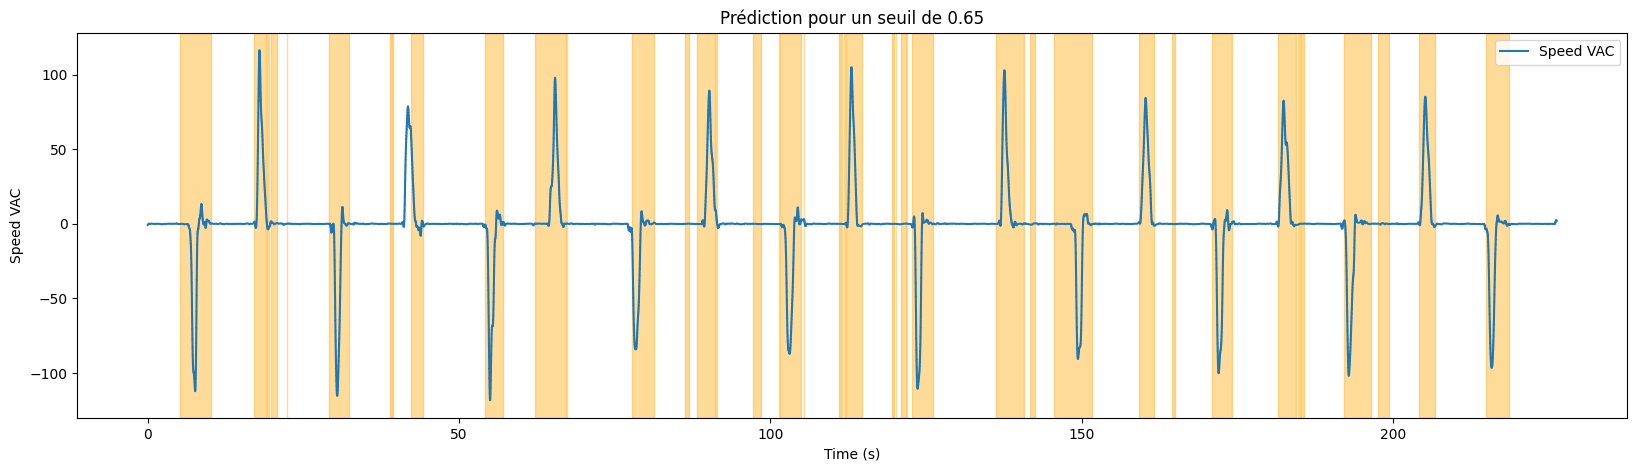

In [30]:
pipeline = results['TangentSpace'][1]
density = sliding_widows_predictions(raw, pipeline, steps=0.2, size=1)
movement_times = threshold(raw, density, threshold=0.65, plot=True, plot_density=False)

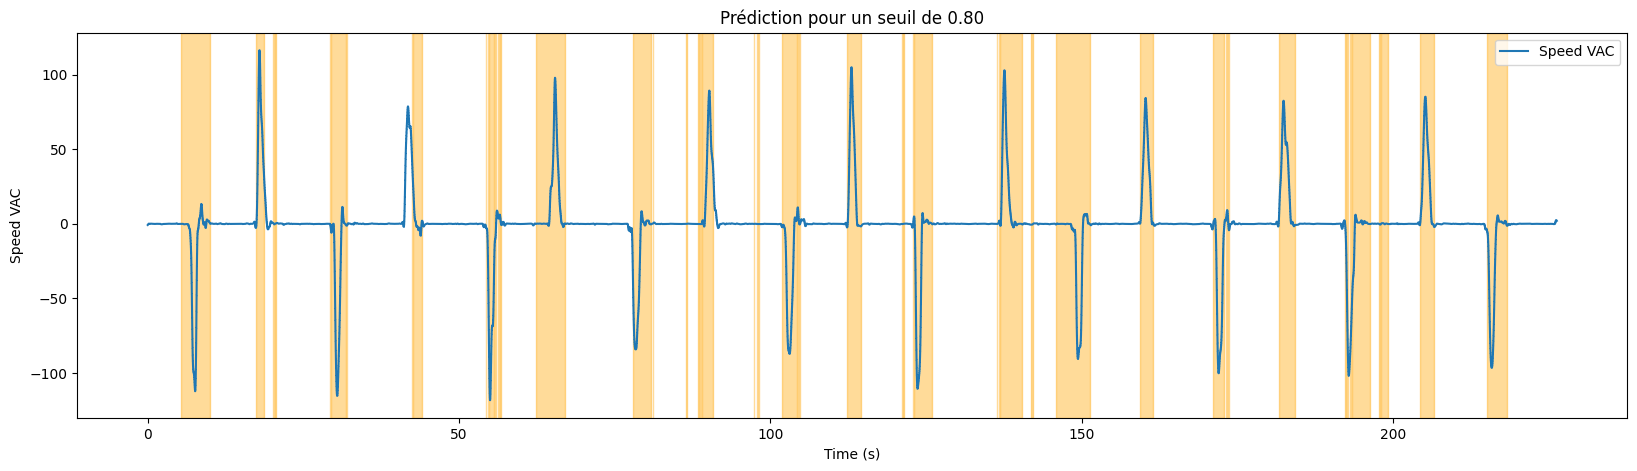

In [31]:
movement_times = threshold(raw, density, threshold=0.8, plot=True, plot_density=False)